In [1]:
import os, cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import precision_score, recall_score, f1_score

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout, Reshape
from keras.optimizers import Adam
from keras.losses import mean_squared_error, binary_crossentropy
from keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose
from tensorflow.keras.metrics import binary_accuracy, mean_squared_error, mean_absolute_error
from tensorflow.keras.saving import register_keras_serializable

from timeit import default_timer as timer

In [3]:
# initialize file paths
cwd = f"{os.getcwd()}/"

image_folder_path = f"{cwd}data/Images/"
annotations_csv_path = f"{cwd}PCB_annotations_dataset.csv"
# initialize image list
image_filenames = os.listdir(image_folder_path)
df_annotations = pd.read_csv(annotations_csv_path, sep=";")

In [5]:
grouped_annotations = df_annotations.groupby('filename')

image_data = []
mask_data = []
class_labels = []

for filename in image_filenames:
    image_path = os.path.join(image_folder_path, filename)
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (600, 600))  
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = image_gray / 255.0 
    image_data.append(image_gray)

    filename = os.path.splitext(filename)[0]
        
    if filename in grouped_annotations.groups:
        df_image_annotation = grouped_annotations.get_group(filename)
        class_label = df_image_annotation['defect'].iloc[0]
        mask = np.zeros_like(image_gray, dtype=np.uint8)
        for _, row in df_image_annotation.iterrows():
            x = int(row['xmin'])
            y = int(row['ymin'])
            w = int(row['xmax']-row['xmin']+1)
            h = int(row['ymax']-row['ymin']+1) 
            mask[y:y+h, x:x+w] = 1
        class_labels.append(class_label)
        mask_data.append(mask)
    else:
        print(f"Image {filename} not found in 'PCB_annotations_dataset.csv'")

X_images = np.asarray(image_data)
y_masks = np.asarray(mask_data)
y_labels = np.asarray(class_labels)

encoder = LabelEncoder()

y_labels_enc = encoder.fit_transform(y_labels)
y_labels_cat = to_categorical(y_labels_enc).astype('uint8')

label_mapping = {index: label for index, label in enumerate(encoder.classes_)}

In [6]:
from collections import Counter

label_counts = Counter(label_mapping.values())
total_labels = sum(label_counts.values())

print("Label Counts:", label_counts)
print("Total Labels:", total_labels)

Label Counts: Counter({'missing_hole': 1, 'mouse_bite': 1, 'open_circuit': 1, 'short': 1, 'spur': 1, 'spurious_copper': 1})
Total Labels: 6


In [7]:
print(f"Shape/type of X_images: {X_images.shape}/{type(X_images)}/{X_images.dtype}")
print(f"Shape/type of y_masks: {y_masks.shape}/{type(y_masks)}/{y_masks.dtype}")
print(f"Shape/type of y_labels_cat: {y_labels_cat.shape}/{type(y_labels_cat)}/{y_labels_cat.dtype}")

Shape/type of X_images: (348, 600, 600)/<class 'numpy.ndarray'>/float64
Shape/type of y_masks: (348, 600, 600)/<class 'numpy.ndarray'>/uint8
Shape/type of y_labels_cat: (348, 6)/<class 'numpy.ndarray'>/uint8


In [8]:
# crop the images and masks to (100, 100)
new_size = (100,100) #image_dim=100x100 

def crop_images(X_images, y_masks, y_labels_cat, new_size):
    if not all(new < orig and orig % new == 0 for orig, new in zip((600, 600), new_size)):
        print("New size must be smaller and a divisor of the original size.")
        return False

    cropped_images = []
    cropped_masks = []
    cropped_labels_cat = []


    for image, mask, labels in zip(X_images, y_masks, y_labels_cat):
        for y in range(0, 600, new_size[0]):
            for x in range(0, 600, new_size[0]):
                y0, x0 = y, x
                y100, x100 = y+new_size[0], x+new_size[0]
                # if a bounding box crosses the cropping border, shift the corresponding border, so defects are not cut off
                while( np.any(mask[y0, x0:x100])) and (y0 != 0): 
                    y0 -= 1
                while (np.any(mask[min(y100, 599), x0:x100])) and (y100 != 600):
                    y100 += 1
                while( np.any(mask[y0:y100, x0])) and (x0 != 0):
                    x0 -= 1
                while( np.any(mask[y0:y100, min(x100, 599)])) and (x100 != 600):
                    x100 += 1
                patch_image = cv2.resize(image[y0:y100, x0:x100], new_size)
                patch_mask = cv2.resize(mask[y0:y100, x0:x100], new_size)
                if np.any(patch_mask):
                    cropped_images.append(patch_image)
                    cropped_masks.append(patch_mask)
                    cropped_labels_cat.append(labels)

    cropped_images = np.array(cropped_images)
    cropped_masks = np.array(cropped_masks)
    cropped_labels_cat = np.array(cropped_labels_cat)
    return cropped_images, cropped_masks, cropped_labels_cat

cropped_images, cropped_masks, cropped_labels_cat = crop_images(X_images, y_masks, y_labels_cat, new_size)

In [9]:
print(f"Shape/type of cropped_images: {cropped_images.shape} / {type(cropped_images)} / {cropped_images.dtype}")
print(f"Shape/type of cropped_masks: {cropped_masks.shape} / {type(cropped_masks)} / {cropped_masks.dtype}")
print(f"Shape/type of cropped_labels_cat: {cropped_labels_cat.shape} / {type(cropped_labels_cat)} / {cropped_labels_cat.dtype}")

Shape/type of cropped_images: (870, 100, 100) / <class 'numpy.ndarray'> / float64
Shape/type of cropped_masks: (870, 100, 100) / <class 'numpy.ndarray'> / uint8
Shape/type of cropped_labels_cat: (870, 6) / <class 'numpy.ndarray'> / uint8


In [10]:
# check for empty masks
for index, mask in enumerate(cropped_masks):
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    if len(cnt) == 0:
        print(index)

In [11]:
# the functions in this cell all serve the following purpose:
# - detect images with exactly two objects in the cropped dataset
# - it does not work yet for the case that there are more than two in an image
# - split those images in two new images
# - replace the original image with two objects with the two single object images

# project the pixel mask onto the x- and y-axis
def compute_projections(mask):
    horizontal_projection = np.sum(mask, axis=1)
    vertical_projection = np.sum(mask, axis=0)
    
    return horizontal_projection, vertical_projection

# list all nonzero blocks in an axis-projection as a dictionary {index: block_length}
def find_nonzero_blocks(projection):
    blocks = {}
    block_length = 0
    for index, value in enumerate(projection):
        if value > 0:
            if block_length == 0:
                key = index
            block_length += 1
        else:
            if block_length > 0:
                blocks[key] = block_length
                block_length = 0
    
    if block_length > 0:
        blocks[key] = block_length

    return blocks

# find indices of images with multiple objects in the cropped_dataset including the x- and y-projections of the objects in the format {index: width}
def find_mult_obj_images(masks):
    mult_obj = []
    #for index, mask in enumerate(cropped_masks):
    for index, mask in enumerate(masks):
        py, px = compute_projections(mask)
        nzby, nzbx = (find_nonzero_blocks(p) for p in (py, px))
        if any((len(nzbx) > 1, len(nzby) > 1)):
            mult_obj.append((index, nzbx, nzby))
    return(mult_obj)

# find and return the index of the first occurence of an image with multiple objects including the x- and y-projections of the objects in the format {index: width}
def find_mult_obj_mask(masks_aray):
    for index, mask in enumerate(masks_aray):
        py, px = compute_projections(mask)
        nzby, nzbx = (find_nonzero_blocks(p) for p in (py, px))
        if any((len(nzbx) > 1, len(nzby) > 1)):
            mult_obj = (index, nzbx, nzby)
            return(mult_obj)
    return False

# takes the output of 'find_mult_obj_mask' and splits the image along the axis along which the two objects have the maximal distance
# does not work for more than two objects yet
def separate_objects(images, masks, mult_object_mask_data):
    index, obj_x, obj_y = mult_object_mask_data

    if any(len(obj) > 2 for obj in (obj_x, obj_y)):
        print("More than two objects on image {index}. Please adapt the function 'separate_objects'.")
        return False
    
    mask = masks[index]
    image = images[index]
    
    left_gap_border = min(obj_x) + obj_x[min(obj_x)]
    right_gap_border = max(obj_x)
    upper_gap_border = min(obj_y) + obj_y[min(obj_y)]
    bottom_gap_border = max(obj_y)
    
    dist_x = right_gap_border - left_gap_border + 1
    dist_y = bottom_gap_border - upper_gap_border + 1
    
    if dist_x >= dist_y:
        sep_position = left_gap_border+dist_x//2
        
        split1_mask = mask[:, :sep_position]
        split2_mask = mask[:, sep_position:]
        split1_image = image[:, :sep_position]
        split2_image = image[:, sep_position:]            
        
        split1_mask = cv2.resize(split1_mask, (100, 100))
        split2_mask = cv2.resize(split2_mask, (100, 100))
        split1_image = cv2.resize(split1_image, (100, 100))
        split2_image = cv2.resize(split2_image, (100, 100))
    else:
        sep_position = upper_gap_border+dist_y//2

        split1_mask = mask[:sep_position, :]
        split2_mask = mask[sep_position:, :]
        split1_image = image[:sep_position, :]
        split2_image = image[sep_position:, :]
                    
        split1_mask = cv2.resize(split1_mask, (100, 100))
        split2_mask = cv2.resize(split2_mask, (100, 100))
        split1_image = cv2.resize(split1_image, (100, 100))
        split2_image = cv2.resize(split2_image, (100, 100))
    
    splitted = (index, [split1_image, split2_image], [split1_mask, split2_mask])
    
    return(splitted)

# replaces images with two objects with two images with one object each as long as there are images with two objects. 
# does not work if there are images with more than two objects
def split_and_replace_mult_obj_data():
    cropped_images_process = cropped_images
    cropped_masks_process = cropped_masks
    cropped_labels_cat_process = cropped_labels_cat
    
    while (mult_obj := find_mult_obj_mask(cropped_masks_process)):
        index, split_images, split_masks = separate_objects(cropped_images_process, cropped_masks_process, mult_obj)
        cropped_images_process = np.delete(cropped_images_process, index, axis=0)
        cropped_images_process = np.append(cropped_images_process, split_images, axis=0)

        cropped_masks_process = np.delete(cropped_masks_process, index, axis=0)
        cropped_masks_process = np.append(cropped_masks_process, split_masks, axis=0)
        
        label = cropped_labels_cat_process[index]
        cropped_labels_cat_process = np.delete(cropped_labels_cat_process, index, axis=0)
        cropped_labels_cat_process = np.append(cropped_labels_cat_process, [label, label], axis=0)
    
    return(cropped_images_process, cropped_masks_process, cropped_labels_cat_process)

In [12]:
# manually check for multiple object images
# not necessary, just for illustration
# multiple object images are handled anyways by 'split_and_replace_mult_obj_data' down below
find_mult_obj_images(cropped_masks)

[(243, {1: 28, 44: 18}, {32: 16, 64: 21}),
 (289, {1: 36, 68: 32}, {17: 56}),
 (312, {8: 38, 72: 28}, {57: 43}),
 (314, {9: 37, 72: 28}, {1: 45}),
 (317, {7: 39, 82: 18}, {1: 35, 68: 32}),
 (325, {38: 30, 81: 19}, {59: 41}),
 (327, {38: 30, 81: 19}, {54: 46}),
 (329, {38: 30, 81: 19}, {1: 35}),
 (362, {36: 28, 75: 25}, {40: 28, 70: 30}),
 (370, {1: 24, 76: 24}, {45: 28, 77: 23}),
 (391, {37: 31, 78: 22}, {60: 40}),
 (393, {37: 31, 78: 22}, {55: 45}),
 (395, {37: 33, 78: 22}, {1: 34, 74: 25}),
 (484, {52: 48}, {1: 33, 70: 30}),
 (485, {1: 66}, {1: 28, 60: 40}),
 (543, {51: 22, 79: 21}, {30: 26, 73: 21}),
 (590, {1: 18, 80: 20}, {48: 20, 85: 15}),
 (668, {1: 19, 53: 27}, {1: 25, 62: 19}),
 (671, {1: 19, 53: 27}, {1: 25, 62: 19}),
 (768, {50: 50}, {1: 17, 40: 36}),
 (769, {1: 38}, {1: 17, 40: 36}),
 (772, {50: 50}, {1: 17, 40: 36}),
 (773, {1: 38}, {1: 17, 40: 36})]

Number of multiple object images: 23


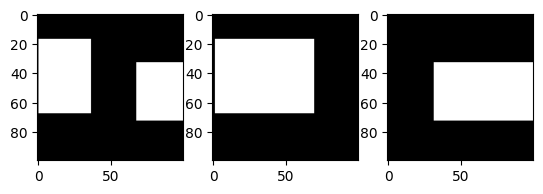

In [13]:
# check the splitting of a chosen example for illustration purposes
mult_obj_img_lst = find_mult_obj_images(cropped_masks)
print(f"Number of multiple object images: {len(mult_obj_img_lst)}")
mobj = mult_obj_img_lst[1] # enter an index here
index, _, [split1_mask, split2_mask] = separate_objects(cropped_images, cropped_masks, mobj)
plt.subplot(131)
plt.imshow(cropped_masks[mobj[0]], cmap='gray')
plt.subplot(132)
plt.imshow(split1_mask, cmap='gray')
plt.subplot(133)
plt.imshow(split2_mask, cmap='gray')
cnt, _ = cv2.findContours(split1_mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

In [14]:
cropped_images_no_mult, cropped_masks_no_mult, cropped_labels_cat_no_mult = split_and_replace_mult_obj_data()


In [15]:
# check for empty masks
for index, mask in enumerate(cropped_masks_no_mult):
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    if len(cnt) == 0:
        print(index)

In [16]:
# check for multiple object images again
find_mult_obj_mask(cropped_masks_no_mult)

False

In [17]:
# check dimensions
print(f"Shape of cropped_images: {cropped_images.shape}")
print(f"Shape of cropped_masks: {cropped_masks.shape}")
print(f"Shape of cropped_labels_cat: {cropped_labels_cat.shape}")
print(f"Shape of cropped_images_no_mult: {cropped_images_no_mult.shape}")
print(f"Shape of cropped_masks_no_mult: {cropped_masks_no_mult.shape}")
print(f"Shape of cropped_labels_cat_no_mult: {cropped_labels_cat_no_mult.shape}")

Shape of cropped_images: (870, 100, 100)
Shape of cropped_masks: (870, 100, 100)
Shape of cropped_labels_cat: (870, 6)
Shape of cropped_images_no_mult: (894, 100, 100)
Shape of cropped_masks_no_mult: (894, 100, 100)
Shape of cropped_labels_cat_no_mult: (894, 6)


In [18]:
# Split data into train and validation sets
X_train, X_test, y_train_masks, y_test_masks, y_train_labels_cat, y_test_labels_cat = train_test_split(cropped_images_no_mult, cropped_masks_no_mult, cropped_labels_cat_no_mult, 
                                                                                                      test_size=0.2, random_state=666)

In [19]:
# check dimensions
print("X_train shape:", X_train.shape)
print("y_train_mask shape:", y_train_masks.shape)
print("y_train_labels_cat shape:", y_train_labels_cat.shape)
print("X_test shape:", X_test.shape)  
print("y_test_masks shape:", y_test_masks.shape)
print("y_test_labels_cat shape:", y_test_labels_cat.shape)

X_train shape: (715, 100, 100)
y_train_mask shape: (715, 100, 100)
y_train_labels_cat shape: (715, 6)
X_test shape: (179, 100, 100)
y_test_masks shape: (179, 100, 100)
y_test_labels_cat shape: (179, 6)


In [20]:
# Data Augmentation:
# rotation ,width_shift, height_shift, shear, zoom, horizontal_flip

def augment_data(images, masks, labels):
    augmented_images = []
    augmented_masks = []
    augmented_labels = []

    for image, mask, labels in zip(images, masks, labels):
        augmented_images.append(image)
        augmented_masks.append(mask)
        augmented_labels.append(labels)

        shear_image, shear_mask = shear(image, mask)
        augmented_images.append(shear_image)
        augmented_masks.append(shear_mask)
        augmented_labels.append(labels)
        # print("Shear:", shear_image.shape, shear_mask.shape)

        flip_image, flip_mask = flip(image, mask)
        augmented_images.append(flip_image)
        augmented_masks.append(flip_mask)
        augmented_labels.append(labels)
        # print("Flip:", flip_image.shape, flip_mask.shape)

        zoom_image, zoom_mask = zoom(image, mask)
        augmented_images.append(zoom_image)
        augmented_masks.append(zoom_mask)
        augmented_labels.append(labels)
        # print("Zoom:", zoom_image.shape, zoom_mask.shape)

        width_shift_image, width_shift_mask = width_shift(image, mask)
        augmented_images.append(width_shift_image)
        augmented_masks.append(width_shift_mask)
        augmented_labels.append(labels)
        # print("Width Shift:", width_shift_image.shape, width_shift_mask.shape)

        height_shift_image, height_shift_mask = height_shift(image, mask)
        augmented_images.append(height_shift_image)
        augmented_masks.append(height_shift_mask)
        augmented_labels.append(labels)
        # print("Height Shift:", height_shift_image.shape, height_shift_mask.shape)

        rotate_image, rotate_mask = rotate(image, mask)
        augmented_images.append(rotate_image)
        augmented_masks.append(rotate_mask)
        augmented_labels.append(labels)
        # print("Rotation:", rotate_image.shape, rotate_mask.shape)

    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_masks, augmented_labels

def shear(image, mask):
    shear_factor = np.random.uniform(-0.2, 0.2)
    rows, cols = image.shape[:2]
    shear_matrix = np.float32([[1, shear_factor, 0], [0, 1, 0]])
    shear_image = cv2.warpAffine(image, shear_matrix, (cols, rows))
    shear_mask = cv2.warpAffine(mask, shear_matrix, (cols, rows))

    padded_image = np.zeros(new_size, dtype=np.uint8)
    padded_mask = np.zeros(new_size, dtype=np.uint8)
    padded_image[:rows, :cols] = shear_image
    padded_mask[:rows, :cols] = mask

    return shear_image, shear_mask

def flip(image, mask):
    flip_image = cv2.flip(image, 1)
    flip_mask = cv2.flip(mask, 1)
    return flip_image, flip_mask

def zoom(image, mask):
    zoom_factor = np.random.uniform(0.8, 1.2)
    zoomed_image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor)
    zoomed_mask = cv2.resize(mask, None, fx=zoom_factor, fy=zoom_factor)

    rows, cols = zoomed_image.shape[:2]
    if rows < new_size[0] or cols < new_size[0]:
        pad_rows = max(0, (new_size[0] - rows) // 2)
        pad_cols = max(0, (new_size[0] - cols) // 2)
        zoomed_image = cv2.copyMakeBorder(zoomed_image, pad_rows, new_size[0] - rows - pad_rows, pad_cols, new_size[0] - cols - pad_cols, cv2.BORDER_CONSTANT, value=0)
        zoomed_mask = cv2.copyMakeBorder(zoomed_mask, pad_rows, new_size[0] - rows - pad_rows, pad_cols, new_size[0] - cols - pad_cols, cv2.BORDER_CONSTANT, value=0)
    elif rows > new_size[0] or cols > new_size[0]:
        zoomed_image = zoomed_image[:new_size[0], :new_size[0]]
        zoomed_mask = zoomed_mask[:new_size[0], :new_size[0]]

    return zoomed_image, zoomed_mask

def width_shift(image, mask):
    shift_x = np.random.uniform(-0.2, 0.2) * image.shape[1]
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, 0]])
    width_shift_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    width_shift_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))

    if width_shift_image.shape[1] > new_size[0]:
        width_shift_image = width_shift_image[:, :new_size[0]]
        width_shift_mask = width_shift_mask[:, :new_size[0]]
    elif width_shift_image.shape[1] < new_size[0]:
        pad_width = new_size[0] - width_shift_image.shape[1]
        width_shift_image = np.pad(width_shift_image, ((0, 0), (0, pad_width), (0, 0)), mode='constant')
        width_shift_mask = np.pad(width_shift_mask, ((0, 0), (0, pad_width), (0, 0)), mode='constant')

    return width_shift_image, width_shift_mask

def height_shift(image, mask):
    shift_y = np.random.uniform(-0.2, 0.2) * image.shape[0]
    translation_matrix = np.float32([[1, 0, 0], [0, 1, shift_y]])
    height_shift_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    height_shift_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))

    if height_shift_image.shape[0] > new_size[0]:
        height_shift_image = height_shift_image[:new_size[0], :]
        height_shift_mask = height_shift_mask[:new_size[0], :]
    elif height_shift_image.shape[0] < new_size[0]:
        pad_height = new_size[0] - height_shift_image.shape[0]
        height_shift_image = np.pad(height_shift_image, ((0, pad_height), (0, 0), (0, 0)), mode='constant')
        height_shift_mask = np.pad(height_shift_mask, ((0, pad_height), (0, 0), (0, 0)), mode='constant')

    return height_shift_image, height_shift_mask

def rotate(image, mask):
    angle = np.random.uniform(-20, 20)
    rows, cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotate_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    rotate_mask = cv2.warpAffine(mask, rotation_matrix, (cols, rows))

    if rotate_image.shape[0] > new_size[0] or rotate_image.shape[1] > new_size[0]:
        rotate_image = cv2.resize(rotate_image, new_size)
        rotate_mask = cv2.resize(rotate_mask, new_size)
    elif rotate_image.shape[0] < new_size[0] or rotate_image.shape[1] < new_size[0]:
        pad_height = max(0, new_size[0] - rotate_image.shape[0])
        pad_width = max(0, new_size[0] - rotate_image.shape[1])
        rotate_image = np.pad(rotate_image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
        rotate_mask = np.pad(rotate_mask, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')

    return rotate_image, rotate_mask


In [21]:
X_train_augmented, y_train_masks_augmented, y_train_labels_cat_augmented = augment_data(X_train, y_train_masks, y_train_labels_cat)

In [22]:
# check dimensions
print("X_train shape:", X_train.shape)
print("y_train_masks shape:", y_train_masks.shape)
print("y_train_labels_cat shape:", y_train_labels_cat.shape)

print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_masks_augmented shape:", y_train_masks_augmented.shape)
print("y_train_labels_cat_augmented shape:", y_train_labels_cat_augmented.shape)

X_train shape: (715, 100, 100)
y_train_masks shape: (715, 100, 100)
y_train_labels_cat shape: (715, 6)
X_train_augmented shape: (5005, 100, 100)
y_train_masks_augmented shape: (5005, 100, 100)
y_train_labels_cat_augmented shape: (5005, 6)


In [23]:
# check for empty masks and masks with dotted object border lines
print("Empty masks:")
for index, mask in enumerate(y_train_masks_augmented):
    cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    if len(cnt) == 0:
        print(index)

print(f"Masks with dotted lines: {find_mult_obj_images(y_train_masks_augmented)}")

Empty masks:
39
290
389
1509
2069
3574
4385
4477
Masks with dotted lines: []


In [24]:
# check for empty masks that were potentially produced by augmentation and remove those data
def detect_no_object_data(masks):
    for index, mask in enumerate(masks):
        cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
        if len(cnt) == 0:
            return(index)
    return False   
    
def remove_no_object_data(index, images, masks, labels):
    updated_images = np.delete(images, index, axis=0)
    updated_masks = np.delete(masks, index, axis=0)
    updated_labels = np.delete(labels, index, axis=0)
    return(updated_images, updated_masks, updated_labels)

while (index := detect_no_object_data(y_train_masks_augmented)):
    X_train_augmented, y_train_masks_augmented, y_train_labels_cat_augmented = remove_no_object_data(index, X_train_augmented, y_train_masks_augmented, y_train_labels_cat_augmented)
    

# remove images with only dotted border of objects in image
while (border_obj := find_mult_obj_mask(y_train_masks_augmented)):
    X_train_augmented = np.delete(X_train_augmented, border_obj[0], axis=0)
    y_train_masks_augmented = np.delete(y_train_masks_augmented, border_obj[0], axis=0)
    y_train_labels_cat_augmented = np.delete(y_train_labels_cat_augmented, border_obj[0], axis=0)

In [25]:
'''
def build_bboxes_channel(masks):
    bboxes = []
    for index, mask in enumerate(masks):
        cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
        if len(cnt) == 1:
            x, y, w, h = cv2.boundingRect(cnt[0])
            bbox = np.array([x, y, w, h])
            #combined_array = np.expand_dims(X_train_augmented[index], axis=-1)
            #combined_array = np.repeat(combined_array, 4, axis=-1)
            #combined_array[2] = bbox_array
            bboxes.append(bbox)
        else:
            print("No or mutliple object(s) in image {index}.")
    bboxes = np.asarray(bboxes).astype('uint8')
    return(bboxes)
'''

# I am removing this part of the code for now. We will discuss if it is needed.
# For label classification we only need the y_train_labels_cat_augmented

'\ndef build_bboxes_channel(masks):\n    bboxes = []\n    for index, mask in enumerate(masks):\n        cnt, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)\n        if len(cnt) == 1:\n            x, y, w, h = cv2.boundingRect(cnt[0])\n            bbox = np.array([x, y, w, h])\n            #combined_array = np.expand_dims(X_train_augmented[index], axis=-1)\n            #combined_array = np.repeat(combined_array, 4, axis=-1)\n            #combined_array[2] = bbox_array\n            bboxes.append(bbox)\n        else:\n            print("No or mutliple object(s) in image {index}.")\n    bboxes = np.asarray(bboxes).astype(\'uint8\')\n    return(bboxes)\n'

In [26]:
'''
# add a bounding box channel to the train and test set
y_train_bboxes_augmented = build_bboxes_channel(y_train_masks_augmented)
y_test_bboxes = build_bboxes_channel(y_test_masks)
'''

'\n# add a bounding box channel to the train and test set\ny_train_bboxes_augmented = build_bboxes_channel(y_train_masks_augmented)\ny_test_bboxes = build_bboxes_channel(y_test_masks)\n'

In [27]:
# check dimensions
print("X_train shape:", X_train.shape)
print("y_train_masks shape:", y_train_masks.shape)
print("y_train_labels_cat shape:", y_train_labels_cat.shape)

print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_masks_augmented shape:", y_train_masks_augmented.shape)
# print("y_train_bboxes_augmented shape:", y_train_bboxes_augmented.shape)
print("y_train_labels_cat_augmented shape:", y_train_labels_cat_augmented.shape)

print("X_test shape:", X_test.shape)
print("y_test_masks shape:", y_test_masks.shape)
# print("y_test_bboxes shape:", y_test_bboxes.shape)
print("y_test_label_cat shape:", y_test_labels_cat.shape)

X_train shape: (715, 100, 100)
y_train_masks shape: (715, 100, 100)
y_train_labels_cat shape: (715, 6)
X_train_augmented shape: (4997, 100, 100)
y_train_masks_augmented shape: (4997, 100, 100)
y_train_labels_cat_augmented shape: (4997, 6)
X_test shape: (179, 100, 100)
y_test_masks shape: (179, 100, 100)
y_test_label_cat shape: (179, 6)


In [28]:
# Combining images and masks into tuples
combined_data = list(zip(X_train_augmented, 
                         y_train_masks_augmented, 
                        #  y_train_bboxes_augmented, 
                        y_train_labels_cat_augmented))

In [29]:
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [30]:
early_stopping = EarlyStopping(
                                patience=2, 
                                min_delta = 0.005, 
                                verbose=1,
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, 
                                    episilon= 0.01,
                                    factor=0.1,  
                                    cooldown = 2, 
                                    verbose=1)

time_callback = TimingCallback()


In [31]:
def enhanced_unet(input_shape, num_classes):    # _with_classification
    
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom 
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)

    # Decoder
    up1 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    up1 = layers.concatenate([up1, conv2], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)

    up2 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
    up2 = layers.concatenate([up2, conv1], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)

    # Segmentation output
    segmentation_output = layers.Conv2D(1, 1, activation='sigmoid', name='segmentation_output')(conv5)

    # Classification head
    classification_flatten = layers.Flatten()(conv3)
    dense1 = layers.Dense(128, activation='relu')(classification_flatten)
    dropout = layers.Dropout(0.5)(dense1)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(dropout)

    # Create model
    model = models.Model(inputs=inputs, outputs=[segmentation_output, classification_output])
    return model

In [32]:
# Instantiate the model
num_classes = total_labels
model = enhanced_unet(input_shape=(new_size[0], new_size[1], 1), num_classes=num_classes)

In [35]:
@register_keras_serializable()
def combined_loss(y_true, y_pred):
    # Segmentation loss
    segm_true = y_true[0]
    segm_pred = y_pred[0]
    segm_loss = binary_crossentropy(segm_true, segm_pred)
    
    # # Bounding box loss
    # bbox_true = y_true[1]
    # bbox_pred = y_pred[1]
    # bbox_loss = mean_squared_error(bbox_true, bbox_pred)

    # Classification loss
    label_true = y_true[1]
    label_pred = y_pred[1]
    label_loss = categorical_crossentropy(label_true, label_pred)
    
    # Weights for segmentation and bounding box loss
    alpha = 0.8  
    beta = 0.2 
    
    # Combined loss
    combined_loss = alpha * segm_loss + beta * label_loss
    
    return combined_loss

@register_keras_serializable()
def segm_metric_accuracy(y_true, y_pred):
    segm_true = y_true[0]
    segm_pred = y_pred[0]
    return binary_accuracy(segm_true, segm_pred)

@register_keras_serializable()
def segm_metric_mae(y_true, y_pred):
    segm_true = y_true[0]
    segm_pred = y_pred[0]
    return mean_absolute_error(segm_true, segm_pred)
 

@register_keras_serializable()
def label_metric(y_true, y_pred):
    label_true = y_true[1]
    label_pred = y_pred[1]
    return binary_accuracy(label_true, label_pred)

In [36]:
iou_metric = MeanIoU(num_classes=num_classes)

In [42]:
# Compile the model with weighted losses
model.compile(
    optimizer='adam',
    loss={
        'segmentation_output': 'binary_crossentropy',  # for the mask output
        'classification_output': 'categorical_crossentropy'  # for the classification output
    },
    loss_weights={
        'segmentation_output': 0.8,  # Weighted at 80%
        'classification_output': 0.2  # Weighted at 20%
    },
    metrics={
        'segmentation_output': ['accuracy', iou_metric, MeanAbsoluteError()],  # Adding IoU and MAE for mask
        'classification_output': ['accuracy', Precision(), Recall()]  # for classification
    }
)

In [43]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 100,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 100,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 100, 100,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 50, 50,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 50,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 25,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 25, 25,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 25, 25,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 25, 25,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │      1,024 │ conv2d_6[0][0]  

 Total params: 22,938,823 (87.50 MB)

 Trainable params: 22,935,751 (87.49 MB)

 Non-trainable params: 3,072 (12.00 KB)

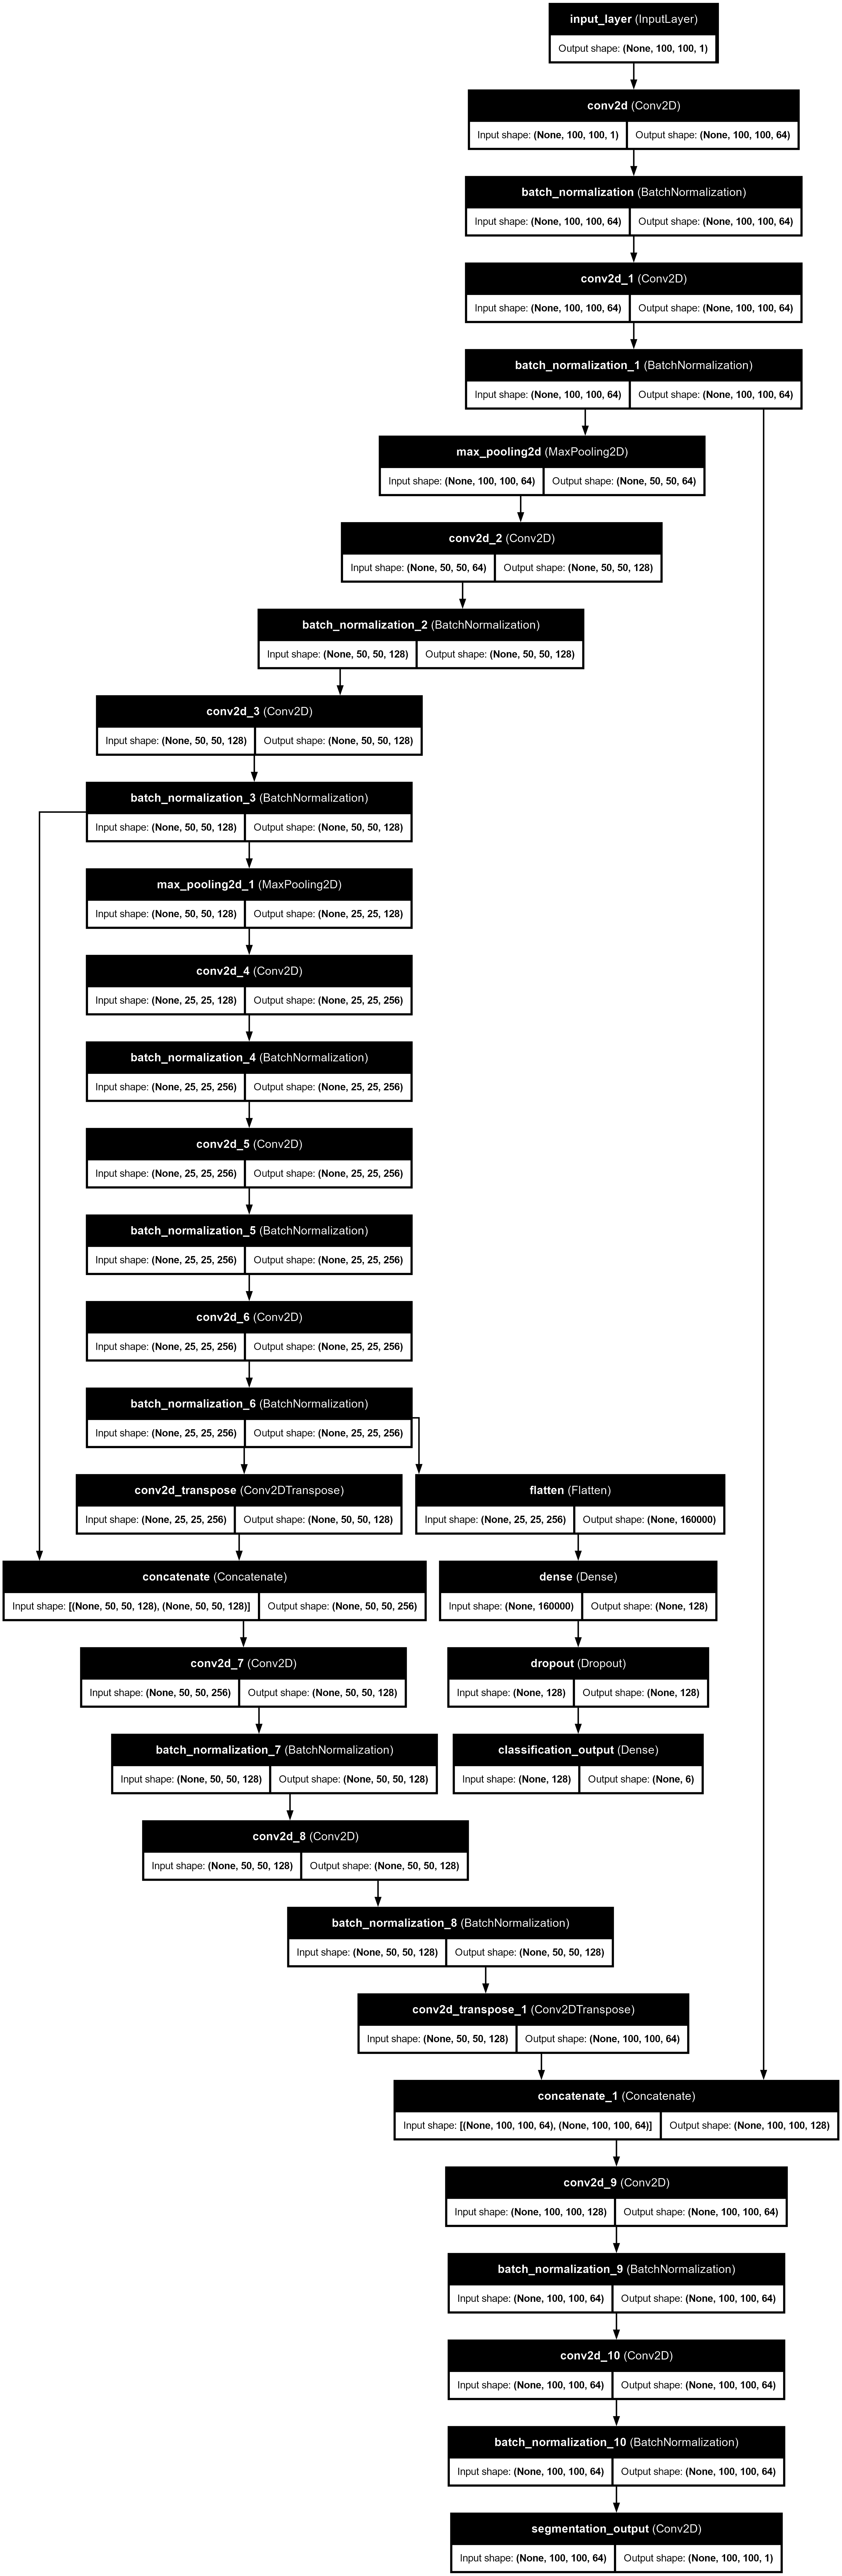

In [44]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_unet_classification.png', show_shapes=True, show_layer_names=True)

In [45]:
print(f"X_train_augmented shape: {type(X_train_augmented)}, {X_train_augmented.shape}")
print(f"y_train_masks_augmented shape: {type(y_train_masks_augmented)}, {y_train_masks_augmented.shape}")
# print(f"y_train_bboxes_augmented shape: {type(y_train_bboxes_augmented)}, {y_train_bboxes_augmented.shape}")
print(f"y_train_labels_cat_augmented shape: {type(y_train_labels_cat_augmented)}, {y_train_labels_cat_augmented.shape}")

print("X_test shape:", X_test.shape)
print("y_test_masks shape:", y_test_masks.shape)
# print("y_test_bboxes shape:", y_test_bboxes.shape)
print("y_test_labels_cat shape:", y_test_labels_cat.shape)

print("Expected input shape for the model:", model.input_shape)

print("Model output shape:", model.output_shape)

print("Data type of y_train_masks_augmented:", y_train_masks_augmented.dtype)
# print("Data type of y_train_bboxes_augmented:", y_train_bboxes_augmented.dtype)
print("Data type of y_train_labels_cat_augmented:", y_train_labels_cat_augmented.dtype)

X_train_augmented shape: <class 'numpy.ndarray'>, (4997, 100, 100)
y_train_masks_augmented shape: <class 'numpy.ndarray'>, (4997, 100, 100)
y_train_labels_cat_augmented shape: <class 'numpy.ndarray'>, (4997, 6)
X_test shape: (179, 100, 100)
y_test_masks shape: (179, 100, 100)
y_test_labels_cat shape: (179, 6)
Expected input shape for the model: (None, 100, 100, 1)
Model output shape: [(None, 100, 100, 1), (None, 6)]
Data type of y_train_masks_augmented: uint8
Data type of y_train_labels_cat_augmented: uint8


In [47]:
# Train the model
history = model.fit(x=X_train_augmented, 
                    y=[y_train_masks_augmented, y_train_labels_cat_augmented],
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, [y_test_masks, y_test_labels_cat]),
                    callbacks=[reduce_learning_rate, time_callback],
                    verbose=True)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - classification_output_accuracy: 0.2134 - classification_output_precision_1: 0.0831 - classification_output_recall_1: 1.7806e-04 - loss: 0.5311 - segmentation_output_accuracy: 0.9303 - segmentation_output_mean_absolute_error: 0.1417 - segmentation_output_mean_io_u: 0.4557 - val_classification_output_accuracy: 0.2123 - val_classification_output_precision_1: 0.2202 - val_classification_output_recall_1: 0.2067 - val_loss: 1.5207 - val_segmentation_output_accuracy: 0.8969 - val_segmentation_output_mean_absolute_error: 0.1254 - val_segmentation_output_mean_io_u: 0.4483 - learning_rate: 0.0010
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 503s 3s/step - classification_output_accuracy: 0.2130 - classification_output_precision_1: 0.1339 - classification_output_recall_1: 1.9051e-04 - loss: 0.4781 - segmentation_output_accuracy: 0.9491 - segmentation_output_mean_absolute_error: 0.0876 - segmentation_output_mean_io_u: 0.4557 - val_classification_out

In [48]:
saved_model = model.save('model_unet_trained_on_2x100.keras')
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_unet_training_history_on_2x100.csv', index=False)
model.save('model_unet_classification.keras')
model.save('model_unet_classification.h5')

In [50]:
# F1=2×(precisionxrecall)/(precision+recall)

def calculate_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-10)

In [55]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

train_acc = history.history["classification_output_accuracy"]
val_acc = history.history["val_classification_output_accuracy"]

train_acc_seg = history.history["segmentation_output_accuracy"]
val_acc_seg = history.history["val_segmentation_output_accuracy"]

train_meanIOU = history.history["segmentation_output_mean_io_u"]
val_meanIOU = history.history["val_segmentation_output_mean_io_u"]

train_mae = history.history["segmentation_output_mean_absolute_error"]
val_mae = history.history["val_segmentation_output_mean_absolute_error"]

train_precision = history.history["classification_output_precision_1"]
val_precision = history.history["val_classification_output_precision_1"]

train_recall = history.history["classification_output_recall_1"]
val_recall = history.history["val_classification_output_recall_1"]

train_F1_score = [calculate_f1_score(precision, recall) for precision, recall in zip(train_precision, train_recall)]
val_F1_score = [calculate_f1_score(precision, recall) for precision, recall in zip(val_precision, val_recall)]


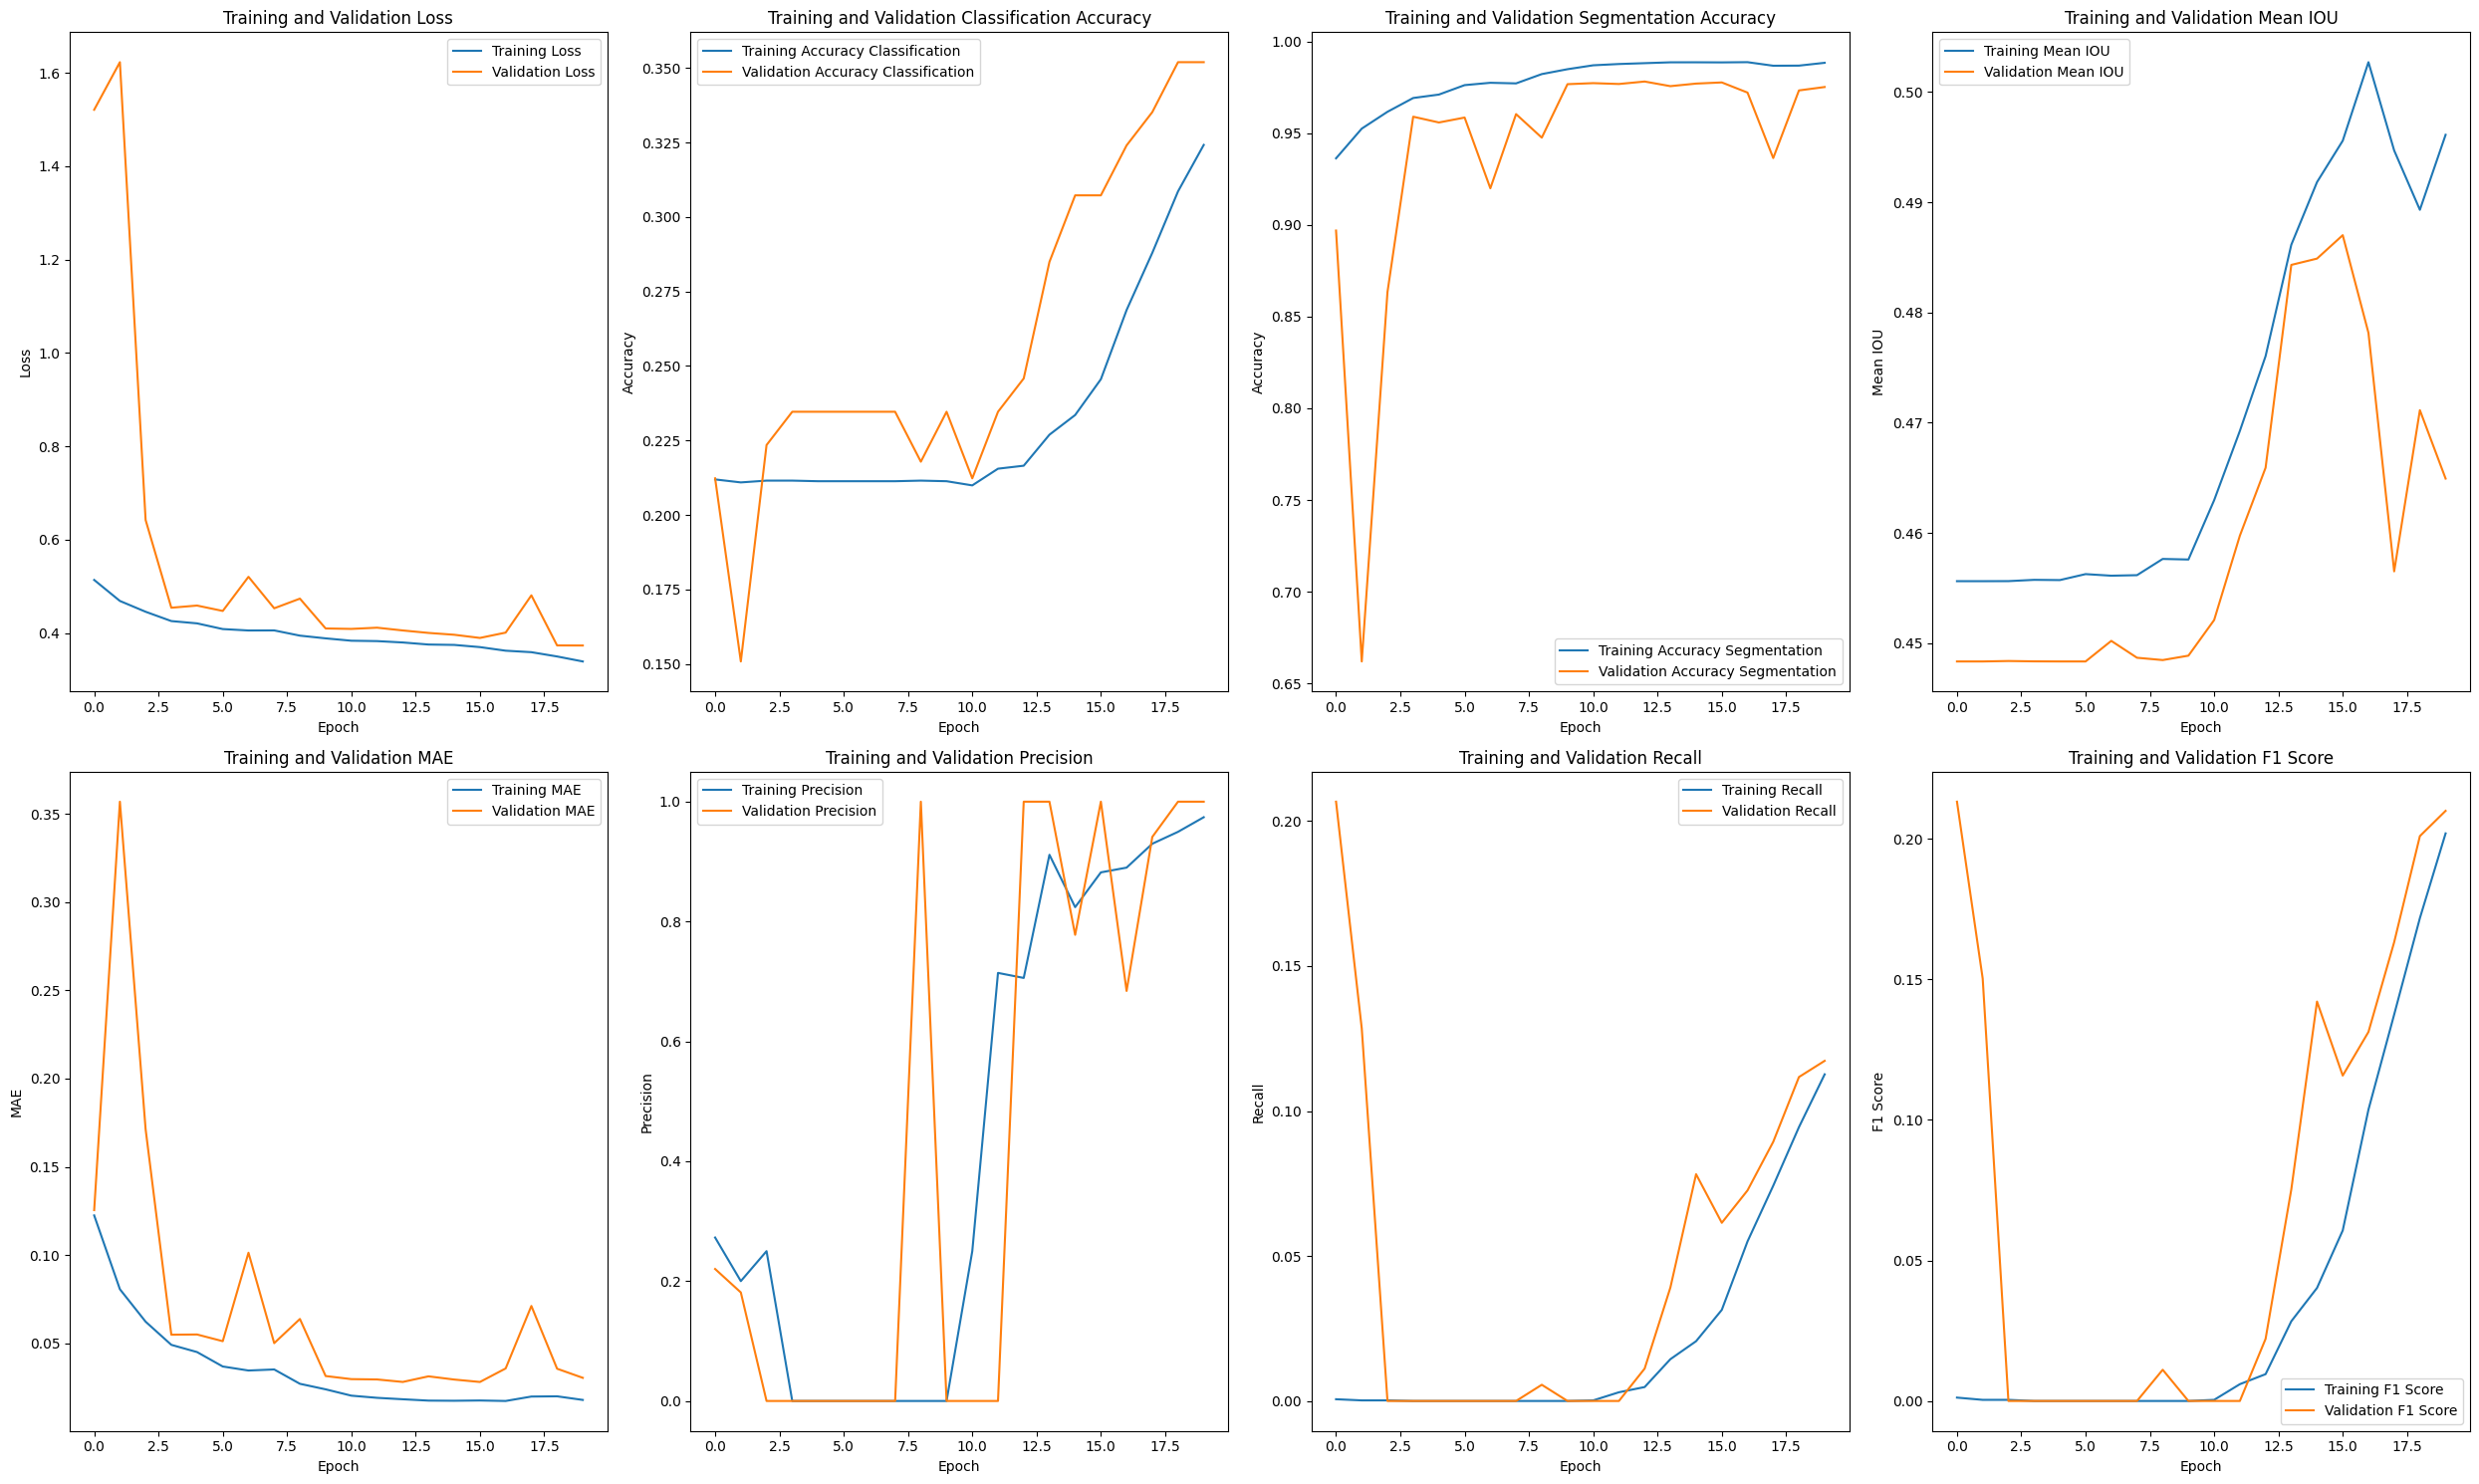

In [56]:

plt.figure(figsize = (25,15))

plt.subplot(2, 4, 1)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(2, 4, 2)
plt.plot(train_acc, label="Training Accuracy Classification")
plt.plot(val_acc, label="Validation Accuracy Classification")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Classification Accuracy")
plt.legend()

plt.subplot(2, 4, 3)
plt.plot(train_acc_seg, label="Training Accuracy Segmentation")
plt.plot(val_acc_seg, label="Validation Accuracy Segmentation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Segmentation Accuracy")
plt.legend()

plt.subplot(2, 4, 4)
plt.plot(train_meanIOU, label="Training Mean IOU")
plt.plot(val_meanIOU, label="Validation Mean IOU")
plt.xlabel("Epoch")
plt.ylabel("Mean IOU")
plt.title("Training and Validation Mean IOU")
plt.legend()

plt.subplot(2, 4, 5)
plt.plot(train_mae, label="Training MAE")
plt.plot(val_mae, label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training and Validation MAE")
plt.legend()

plt.subplot(2, 4, 6)
plt.plot(train_precision, label="Training Precision")
plt.plot(val_precision, label="Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Training and Validation Precision")
plt.legend()

plt.subplot(2, 4, 7)
plt.plot(train_recall, label="Training Recall")
plt.plot(val_recall, label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Training and Validation Recall")
plt.legend()

plt.subplot(2, 4, 8)
plt.plot(train_F1_score, label="Training F1 Score")
plt.plot(val_F1_score, label="Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
y_val_masks, y_val_label = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step


In [61]:
predicted_labels = np.argmax(y_val_label, axis=1)
#print("Predicted Labels:", predicted_labels)

In [62]:
class_labels_pred = {
    0: 'missing_hole',
    1: 'mouse_bite',
    2: 'open_circuit',
    3: 'short',
    4: 'spur',
    5: 'spurious_copper'
}
# Remap predicted labels to label names
remapped_labels = [class_labels_pred[label] for label in predicted_labels]

# Print the remapped labels
print("Remapped Labels:", remapped_labels)

Remapped Labels: ['short', 'short', 'short', 'short', 'missing_hole', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'missing_hole', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'missing_hole', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'missing_hole', 'short', 'missing_hole', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'missing_hole', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'missing_hole', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'missing_hole', 'short', 'short', 'short', 'short', 'short', 'missing_hole', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'short', 'missing_hole', 'short', 'missing_hole', 'shor

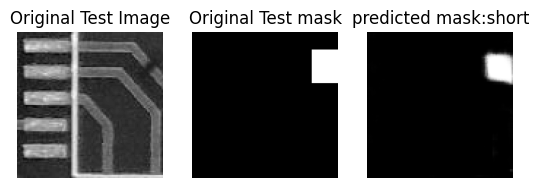

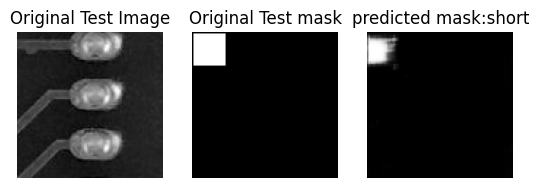

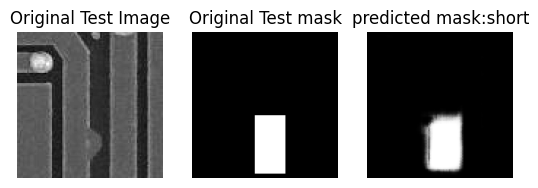

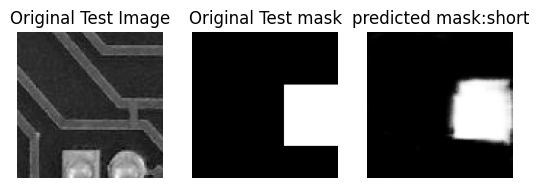

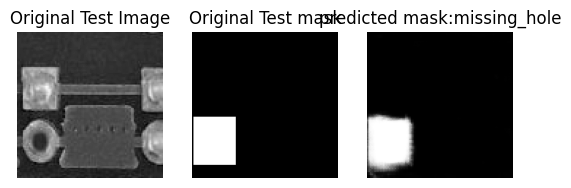

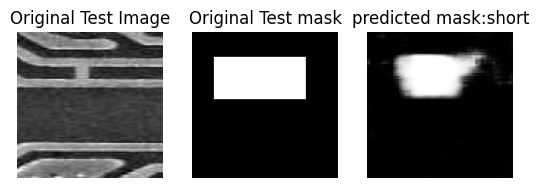

In [63]:

for i in np.random.choice(X_test.shape[0], replace=False, size=6):
    plt.subplot(131) 
    plt.imshow(X_test[i].squeeze(), cmap='gray')  
    plt.title('Original Test Image')
    plt.axis('off')

    plt.subplot(132)  
    plt.imshow(y_test_masks[i].squeeze(), cmap='gray') 
    plt.title('Original Test mask')
    plt.axis('off')

    plt.subplot(133)  
    plt.imshow(y_val_masks[i].squeeze(), cmap='gray')  
    plt.title('predicted mask:'+remapped_labels[i])
    plt.axis('off')

    plt.show()
    